In [2]:
# instalamos las librerias necesarias
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17269 (from 2)
Receiving objects: 100% (17270/17270), 16.11 MiB | 31.29 MiB/s, done.
Resolving deltas: 100% (11861/11861), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Descomprimimos el dataset

In [1]:
import shutil


zip_path = "/content/archive.zip"
extract_path = "/content"

shutil.unpack_archive(zip_path, extract_path, 'zip')

print("Descompresión completa!")

Descompresión completa!


## Creamos el dataset personalizado para yolo

In [5]:
import os
import random
import shutil

# Definir rutas
original_dataset_path = "/content/Dataset"
yolo_dataset_path = "/content/dataset_yolo"

# Clases a considerar en YOLO (Bus se ignora)
classes = ["Moto", "Coche", "Furgoneta", "Camion"]  # Asigna manualmente "Camion" si tienes imágenes de él
class_to_id = {cls: idx for idx, cls in enumerate(classes)}

# Crear carpetas para el nuevo dataset en formato YOLO
for split in ["train", "val"]:
    os.makedirs(os.path.join(yolo_dataset_path, "images", split), exist_ok=True)
    os.makedirs(os.path.join(yolo_dataset_path, "labels", split), exist_ok=True)

# Proporción de validación (20%)
split_ratio = 0.2

# Procesar cada clase
for class_name in os.listdir(original_dataset_path):
    class_path = os.path.join(original_dataset_path, class_name)

    # Ignorar la clase "Bus"
    if class_name not in classes:
        print(f"⚠️ Ignorando clase {class_name} (no está en las clases de YOLO)")
        continue

    # Obtener todas las imágenes de la clase
    images = [img for img in os.listdir(class_path) if img.endswith((".jpg", ".png", ".jpeg"))]

    # Mezclar y dividir en train/val
    random.shuffle(images)
    split_idx = int(len(images) * (1 - split_ratio))
    train_images, val_images = images[:split_idx], images[split_idx:]

    # Mover imágenes a la estructura YOLO
    for split, img_list in zip(["train", "val"], [train_images, val_images]):
        for img_name in img_list:
            src_img_path = os.path.join(class_path, img_name)
            dst_img_path = os.path.join(yolo_dataset_path, "images", split, img_name)
            shutil.copy(src_img_path, dst_img_path)

            # Crear archivo de etiqueta en formato YOLO
            label_name = os.path.splitext(img_name)[0] + ".txt"
            label_path = os.path.join(yolo_dataset_path, "labels", split, label_name)

            # En YOLO, las etiquetas deben contener: <class_id> <x_center> <y_center> <width> <height>
            # Como no tenemos bounding boxes, generamos un placeholder (YOLO requiere anotaciones reales)
            with open(label_path, "w") as f:
                f.write(f"{class_to_id[class_name]} 0.5 0.5 1.0 1.0\n")  # Etiqueta con caja completa (se debe corregir manualmente)

print("✅ Dataset reorganizado correctamente en formato YOLO.")

# Crear el archivo dataset.yaml para YOLOv5
dataset_yaml = f"""
path: {yolo_dataset_path}
train: images/train
val: images/val

nc: {len(classes)}
names: {classes}
"""

with open(os.path.join(yolo_dataset_path, "dataset.yaml"), "w") as f:
    f.write(dataset_yaml)

print("✅ dataset.yaml creado correctamente.")


⚠️ Ignorando clase .ipynb_checkpoints (no está en las clases de YOLO)
✅ Dataset reorganizado correctamente en formato YOLO.
✅ dataset.yaml creado correctamente.


## Entrenamos el modelo

In [6]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/dataset_yolo/dataset.yaml --weights yolov5s.pt --device 0


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-02-16 18:09:53.226621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739729393.249459    2704 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739729393.256448    2704 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 3
wandb: You chose "Don't visualize my results"
train: weights=yolov5s.pt, cfg=, data=/content/dataset_yolo/dataset.yaml,

Saving 82-92-letra-j.jpg to 82-92-letra-j (1).jpg
82-92-letra-j (1).jpg
detect: weights=['runs/train/exp2/weights/best.pt'], source=82-92-letra-j (1).jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-398-g5cdad892 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/82-92-letra-j (1).jpg: 480x640 1 Camion, 37.6ms
Speed: 0.5ms pre-process, 37.6ms inference, 128.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp10


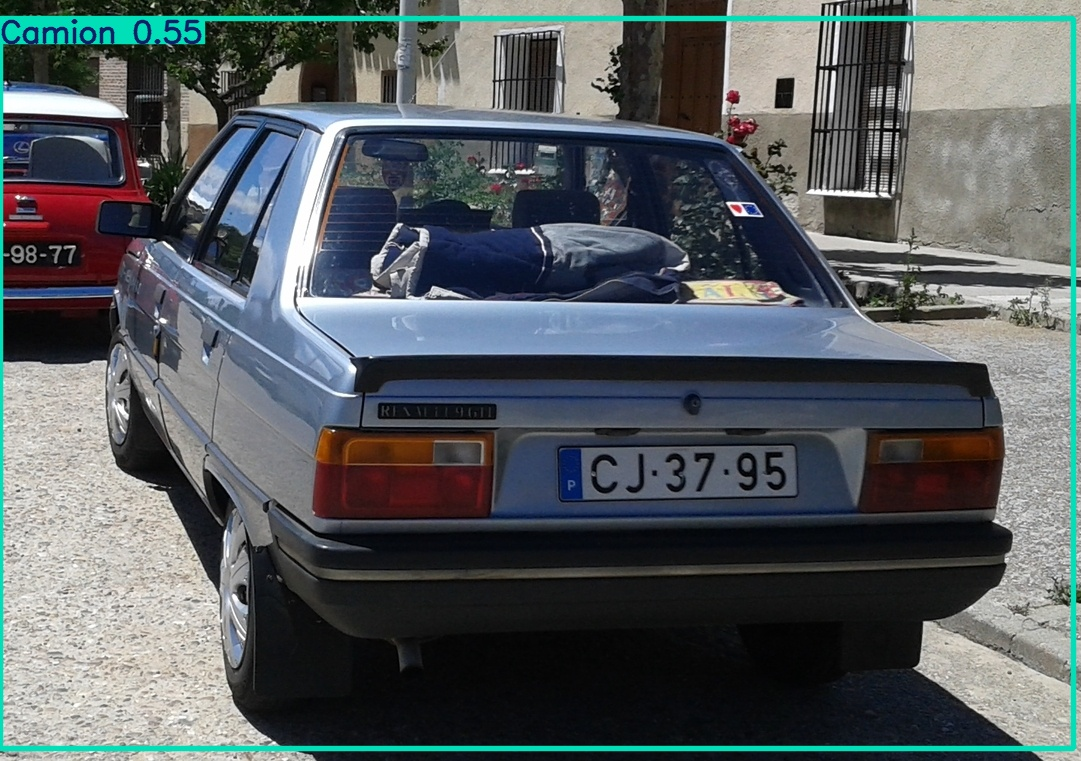

In [19]:
from IPython.display import Image
from google.colab import files
# Subir imagen de prueba
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(image_path)

# Ejecutar detección
!python detect.py --weights runs/train/exp2/weights/best.pt --img 640 --conf 0.4 --source "{image_path}"

# Mostrar resultado
Image(filename=f"runs/detect/exp10/{image_path}")
